In [1]:
pip install pyspark pandas matplotlib seaborn

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("BigDataAnalysis").getOrCreate()

In [3]:
df = spark.read.csv("processed_healthcare_data.csv", header=True, inferSchema=True)

In [5]:
df.printSchema()
df.show(25)

root
 |-- name: string (nullable = true)
 |-- age: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- blood_type: string (nullable = true)
 |-- medical_condition: string (nullable = true)
 |-- date_of_admission: date (nullable = true)
 |-- doctor: string (nullable = true)
 |-- hospital: string (nullable = true)
 |-- insurance_provider: string (nullable = true)
 |-- billing_amount: double (nullable = true)
 |-- room_number: integer (nullable = true)
 |-- admission_type: string (nullable = true)
 |-- discharge_date: date (nullable = true)
 |-- medication: string (nullable = true)
 |-- test_results: string (nullable = true)
 |-- age_group: string (nullable = true)

+-------------------+----+------+----------+-----------------+-----------------+-----------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+---------+
|               name| age|gender|blood_type|medical_condition|date_of_admissi

In [4]:
from pyspark.sql.functions import col, sum
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+----+---+------+----------+-----------------+-----------------+------+--------+------------------+--------------+-----------+--------------+--------------+----------+------------+---------+
|name|age|gender|blood_type|medical_condition|date_of_admission|doctor|hospital|insurance_provider|billing_amount|room_number|admission_type|discharge_date|medication|test_results|age_group|
+----+---+------+----------+-----------------+-----------------+------+--------+------------------+--------------+-----------+--------------+--------------+----------+------------+---------+
|   0|  0|     0|         0|                0|                0|     0|       0|                 0|             0|          0|             0|             0|         0|           0|        0|
+----+---+------+----------+-----------------+-----------------+------+--------+------------------+--------------+-----------+--------------+--------------+----------+------------+---------+



In [7]:
from pyspark.sql.functions import mean

df = df.fillna({"Billing_amount": df.select(mean("Billing_amount")).collect()[0][0]})


In [8]:
from pyspark.sql.functions import upper
df = df.withColumn("Name", upper(col("Name")))

In [9]:
df = df.dropDuplicates()

In [10]:
df.describe().show()

+-------+-----------+------------------+------+----------+-----------------+-----------+--------------------+------------------+-------------------+------------------+--------------+----------+------------+---------+
|summary|       Name|               age|gender|blood_type|medical_condition|     doctor|            hospital|insurance_provider|     billing_amount|       room_number|admission_type|medication|test_results|age_group|
+-------+-----------+------------------+------+----------+-----------------+-----------+--------------------+------------------+-------------------+------------------+--------------+----------+------------+---------+
|  count|      39662|             39662| 39662|     39662|            39662|      39662|               39662|             39662|              39662|             39662|         39662|     39662|       39662|    39662|
|   mean|       NULL| 51.57165548888104|  NULL|      NULL|             NULL|       NULL|                NULL|              NULL| 255

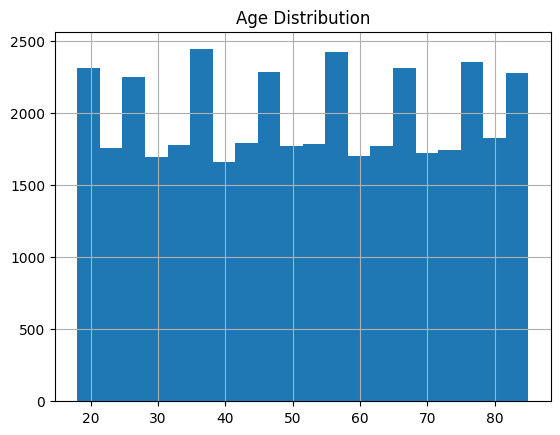

In [11]:
import matplotlib.pyplot as plt

df.select("Age").toPandas().hist(bins=20)
plt.title("Age Distribution")
plt.show()


In [14]:
df.groupBy("medical_condition").count().show()

+-----------------+-----+
|medical_condition|count|
+-----------------+-----+
|          Obesity| 6558|
|         Diabetes| 6611|
|        Arthritis| 6684|
|     Hypertension| 6650|
|           Cancer| 6596|
|           Asthma| 6563|
+-----------------+-----+



In [15]:
df.groupBy("medical_condition").agg({"Billing_amount": "mean"}).show()

+-----------------+-------------------+
|medical_condition|avg(Billing_amount)|
+-----------------+-------------------+
|          Obesity| 25802.432059587474|
|         Diabetes| 25736.712918622015|
|        Arthritis|  25445.47312428553|
|     Hypertension| 25410.077814079836|
|           Cancer| 25246.722734509876|
|           Asthma|  25799.18354665017|
+-----------------+-------------------+



In [16]:
df.groupBy("admission_type", "test_results").count().show()

+--------------+------------+-----+
|admission_type|test_results|count|
+--------------+------------+-----+
|     Emergency|    Abnormal| 4354|
|        Urgent|Inconclusive| 4434|
|        Urgent|      Normal| 4398|
|      Elective|      Normal| 4445|
|        Urgent|    Abnormal| 4459|
|     Emergency|Inconclusive| 4326|
|      Elective|Inconclusive| 4379|
|     Emergency|      Normal| 4342|
|      Elective|    Abnormal| 4525|
+--------------+------------+-----+



In [19]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=["age", "billing_amount"], outputCol="features")
df_vector = assembler.transform(df).select("features")
correlation_matrix = Correlation.corr(df_vector, "features").collect()[0][0]
print(correlation_matrix.toArray())

[[ 1.00000000e+00 -8.72957615e-04]
 [-8.72957615e-04  1.00000000e+00]]


In [20]:
df.groupBy("hospital").agg({"Billing_amount": "sum"}).show()

+--------------------+-------------------+
|            hospital|sum(Billing_amount)|
+--------------------+-------------------+
|           Smith PLC|  807201.8514465074|
|            Inc Diaz|  38465.99180562161|
|Johnson, Baldwin ...| 1988.5311855334735|
|        Aguilar-Bass|  14896.97500213013|
|          Group Park| 52221.107941460694|
|        Sanchez-Cook|  6691.912682535657|
|           Mills Ltd|  11997.37991126259|
|      Reeves-Edwards|  21847.12682622056|
|       Kennedy-Price| 34379.880005306026|
|       Dixon-Jenkins| 10513.192365805622|
|       Group Edwards| 119125.75258882642|
|       Norton-Nelson| 13625.052214539844|
|Mendez, Mitchell ...| 27875.163032405933|
|         Davis-Watts|  49361.09666385883|
|     Hernandez-Smith|  55988.56277597512|
|and Sparks Perkin...|  20037.26305394208|
|        Harmon-Brock| 10962.515206141505|
|Foster Lamb, Grah...| 10659.608812944593|
|Robinson and Hunt...| 30298.843061699987|
|Garcia Bond, Rive...| 35279.187814723424|
+----------

In [22]:
df.filter((col("age") > 50) & (col("medical_condition") == "Cancer")).show()

+----------------+----+------+----------+-----------------+-----------------+------------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+---------+
|            Name| age|gender|blood_type|medical_condition|date_of_admission|            doctor|            hospital|insurance_provider|    billing_amount|room_number|admission_type|discharge_date| medication|test_results|age_group|
+----------------+----+------+----------+-----------------+-----------------+------------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+---------+
|   WILLIAM BAKER|75.0|Female|        O-|           Cancer|       2022-10-13|       John Gaines|        Evans-Torres|             Aetna|2473.4707476105477|        389|        Urgent|    2022-11-08|  Ibuprofen|    Abnormal|   senior|
|     ALYSSA DEAN|84.0|Female|       AB+|           Cancer|       20

In [23]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

window_spec = Window.partitionBy("hospital").orderBy("Billing_amount")
df.withColumn("row_number", row_number().over(window_spec)).show()

+----------------+----+------+----------+-----------------+-----------------+------------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+---------+----------+
|            Name| age|gender|blood_type|medical_condition|date_of_admission|            doctor|            hospital|insurance_provider|    billing_amount|room_number|admission_type|discharge_date| medication|test_results|age_group|row_number|
+----------------+----+------+----------+-----------------+-----------------+------------------+--------------------+------------------+------------------+-----------+--------------+--------------+-----------+------------+---------+----------+
|   HEATHER SMITH|59.0|  Male|        O-|        Arthritis|       2022-08-01|    Jessica Arnold|          Abbott Ltd|  UnitedHealthcare| 29877.58648308568|        198|     Emergency|    2022-08-20|Paracetamol|      Normal|    adult|         1|
|   KIMBERLY CARR|39.0| 

In [30]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

# ✅ Ensure correct column names
df = df.withColumnRenamed("Billing_amount", "billing_amount")  # Just in case

# ✅ Assemble features
assembler = VectorAssembler(inputCols=["age", "billing_amount"], outputCol="features")

# ✅ Define the model
lr = LinearRegression(featuresCol="features", labelCol="billing_amount")

# ✅ Create and fit the pipeline
pipeline = Pipeline(stages=[assembler, lr])
model = pipeline.fit(df)  # Fit model on transformed DataFrame

# ✅ Show model summary
summary = model.stages[-1].summary
print("RMSE:", summary.rootMeanSquaredError)
print("R2 Score:", summary.r2)


RMSE: 4.229521513145369e-12
R2 Score: 1.0


In [31]:
pandas_df = df.toPandas()

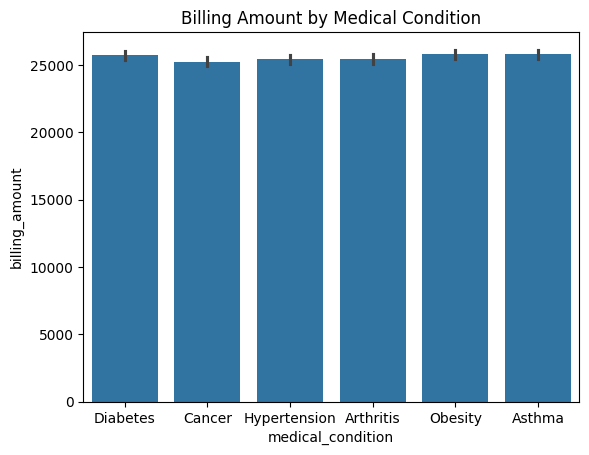

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x="medical_condition", y="billing_amount", data=pandas_df)
plt.title("Billing Amount by Medical Condition")
plt.show()


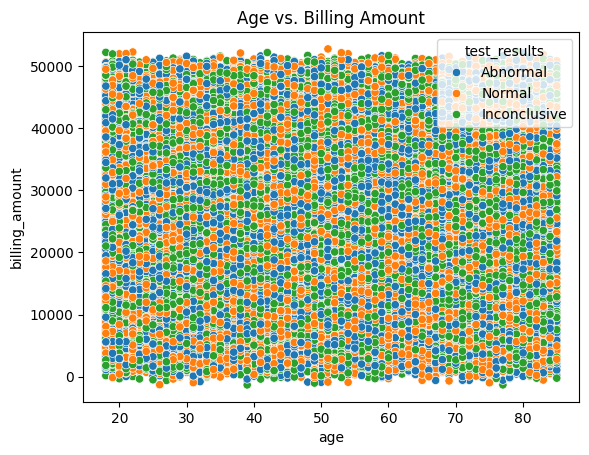

In [36]:
sns.scatterplot(x="age", y="billing_amount", hue="test_results", data=pandas_df)
plt.title("Age vs. Billing Amount")
plt.show()

In [37]:
from google.colab import files
files.download("processed_healthcare_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>